In [ ]:
import os
import json
from sklearn.metrics import accuracy_score
import pandas as pd

In [ ]:

def read_json(path):
    """ Read a json file from the given path."""
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def write_json(path, data):
    """ Write a json file to the given path."""
    if not os.path.exists(os.path.dirname(path)):
        os.makedirs(os.path.dirname(path))

    with open(path, 'w', encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

In [ ]:
def compute_acc(prediction, ground):
  acc = accuracy_score(prediction, ground)
  return acc

**TACRED**

In [ ]:
def get_gt(gt_base, task_id, run_id):
  gts=[]
  print("test")
  print(gt_base)
  for i in range(1, task_id+1):
    gt_path = f'{gt_base}/run_{run_id}/task{i}/test_1.json'
    gt = read_json(gt_path)
    gts.extend([item['relation'] for item in gt])
  return gts

In [ ]:
def get_list_acc(gt_path_base, experiment_result_path, task_1_path, model="t5"):
  results = []
  for run_id   in range(1,6):
    gt_path = f'{gt_path_base}/run_{run_id}/task1/test_1.json'
    gt = read_json(gt_path)
    gt_relations = [item['relation'] for item in gt] # Extract relation labels from ground truth
    size_task1 = len(gt_relations)
    task_1 = read_json(f'{experiment_result_path}/model{run_id}/task_task1_current_task_pred.json')
    if model=='t5':
      results.append({"run":run_id, "task":1, "acc":task_1[0]['acc']})
    else:
      task_1_pred = [item['relation'] for item in task_1]
      # The problem was here: accuracy_score expects two lists of labels, not a list of dictionaries and a list of labels
      # acc = accuracy_score(gt, task_1_pred)  # This line was causing the error
      # Instead, use the extracted relation labels from ground truth (gt_relations)
      acc = accuracy_score(gt_relations, task_1_pred)  # Corrected line
      results.append({"run":run_id, "task":1, "acc":acc})
      print(acc)
    for task_id in range(2, 11):
      print(task_id)
      pred_path = f'{task_1_path}/model{run_id}/task_{task_id}_seen_task.json'
      pred_task_1 = read_json(pred_path)[:len(gt)]
      pred_relations_task_1 = [item['relation'] for item in pred_task_1]
      # Filter out None values from both lists before calculating accuracy, ensuring the lists remain aligned
      # Zip the two lists to iterate through them in parallel
      gt_relations = get_gt(gt_path_base, task_id, run_id)
      filtered_data = [(p, g) for p, g in zip(pred_relations_task_1, gt_relations) if p is not None and g is not None]
      # If filtered_data is empty, set pred_relations_task_1_filtered and gt_relations_filtered to empty lists to avoid errors
      if not filtered_data:
          pred_relations_task_1_filtered = []
          gt_relations_filtered = []
      else:
          # Unzip the filtered data back into separate lists
          pred_relations_task_1_filtered, gt_relations_filtered = zip(*filtered_data)
      task_1_acc = compute_acc(pred_relations_task_1_filtered, gt_relations_filtered)
      results.append({"run":run_id, "task":task_id, "acc":task_1_acc})
  return results

In [ ]:
t5_results = get_list_acc('task_data/test', '/content/t5', 't5')

In [ ]:

t5_df = pd.DataFrame(t5_results)
mean_acc_t5 = t5_df.groupby('task').mean()
std_acc_t5 = t5_df.groupby('task').std()

In [ ]:
mistral_results = get_list_acc('/content/llama_format_data/test', '/content/mistral', '/content/mistral', 'mistral')

In [ ]:
mean_mistral_tacred = pd.DataFrame(mistral_results).groupby('task').mean()['acc']
std_mistral_tacred = pd.DataFrame(mistral_results).groupby('task').std()['acc']

In [ ]:
llama_results = get_list_acc('/content/llama_format_data/test', '/content/llama', '/content/llama', 'llama')

In [ ]:
mean_llama_tacred = pd.DataFrame(llama_results).groupby('task').mean()['acc']
std_llama_tacred = pd.DataFrame(llama_results).groupby('task').std()['acc']

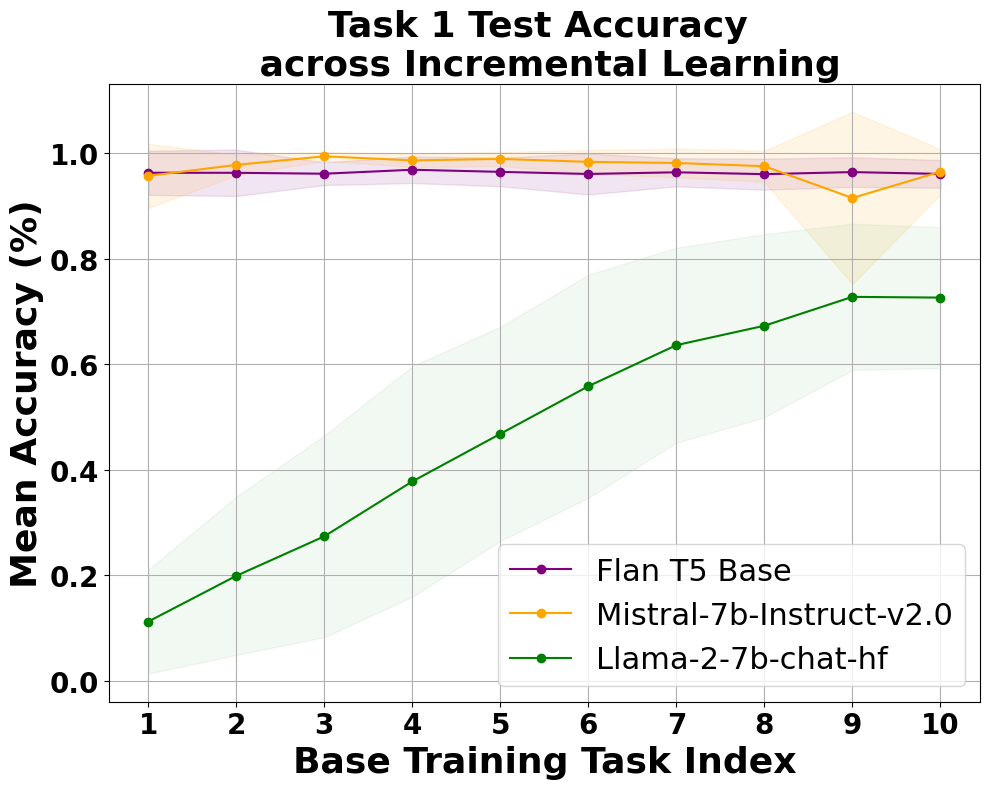

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up figure size
plt.figure(figsize=(10, 8))

# Generate example data
x = [f'{i}' for i in range(1, 11)]  # X values
mean_t5 = mean_acc_t5['acc']  # Line values for Flan T5 Base
std_t5 = std_acc_t5['acc']  # Standard deviation for Flan T5 Base

# Scale data to percentages


# Plot the Flan T5 Base line
plt.plot(x, mean_t5, label='Flan T5 Base', color='purple',  marker='o')

# Plot other models
plt.plot(x, mean_mistral_tacred, label='Mistral-7b-Instruct-v2.0', color='orange',  marker='o')
plt.plot(x, mean_llama_tacred, label='Llama-2-7b-chat-hf', color='green',  marker='o')

# Optionally add the standard deviation as shaded areas (commented out for now)
plt.fill_between(x, np.array(mean_t5) - np.array(std_t5), np.array(mean_t5) + np.array(std_t5),
                 color='purple', alpha=0.1)
plt.fill_between(x, np.array(mean_mistral_tacred) - np.array(std_mistral_tacred),
                 np.array(mean_mistral_tacred) + np.array(std_mistral_tacred),
                 color='orange', alpha=0.1)
plt.fill_between(x, np.array(mean_llama_tacred) - np.array(std_llama_tacred),
                 np.array(mean_llama_tacred) + np.array(std_llama_tacred),
                 color='green', alpha=0.05)

# Customize the plot
plt.title("Task 1 Test Accuracy \n across Incremental Learning", fontsize=26, fontweight='bold')
plt.xlabel("Base Training Task Index", fontsize=26, fontweight='bold')
plt.ylabel("Mean Accuracy (%)", fontsize=26, fontweight='bold')
plt.xticks(fontsize=20, fontweight='bold')  # Rotate x-axis labels and increase font size
plt.yticks(fontsize=20, fontweight='bold')  # Increase font size of y-axis labels
plt.legend(fontsize=22)
plt.grid(True)

# Improve layout and save the figure
plt.tight_layout()
plt.savefig("task1_accuracy_tacred.pdf", dpi=300)
plt.show()
